In [1]:
from math import sqrt
from numpy import concatenate

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.head())
print(reframed.shape)#3 * 8 + 8 columns in our framed dataset. 
#We will take 3 * 8 or 24 columns as input for the obs of all features across the previous 3 hours

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
4   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
5   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
6   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
7   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)   ...     var7(t-1)  var8(t-1)  \
3   0.000000        0.0   0.148893   0.367647   ...      0.000000        0.0   
4   0.000000        0.0   0.159960   0.426471   ...      0.037037        0.0   
5   0.000000        0.0   0.182093   0.485294   ...      0.074074        0.0   
6   0.037037        0.0   0.138833   0.485294   ...      0.111111        0.0   
7   0.074074        0.0   0.109658   0.485294   ...      0.148148        0.0   

    var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)  \
3  0.182093  0.48

In [5]:
 # split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]#(8760, 32)
test = values[n_train_hours:, :]


In [8]:
# split into input and outputs
n_obs = n_hours * n_features #3*8
train_X, train_y = train[:, :n_obs], train[:, -n_features]#前24列，和第24列。t－3，t－2，t－1；y是var1(t)
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
print(train_y)

(8760, 24) 8760 (8760,)
[0.18209255 0.13883299 0.10965794 ... 0.0362173  0.03118712 0.02012072]


In [9]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 2s - loss: 0.0441 - val_loss: 0.0783
Epoch 2/50
 - 2s - loss: 0.0260 - val_loss: 0.0525
Epoch 3/50
 - 2s - loss: 0.0214 - val_loss: 0.0334
Epoch 4/50
 - 2s - loss: 0.0209 - val_loss: 0.0283
Epoch 5/50
 - 1s - loss: 0.0202 - val_loss: 0.0254
Epoch 6/50
 - 1s - loss: 0.0197 - val_loss: 0.0225
Epoch 7/50
 - 1s - loss: 0.0192 - val_loss: 0.0208
Epoch 8/50
 - 1s - loss: 0.0192 - val_loss: 0.0193
Epoch 9/50
 - 1s - loss: 0.0185 - val_loss: 0.0188
Epoch 10/50
 - 1s - loss: 0.0183 - val_loss: 0.0178
Epoch 11/50
 - 1s - loss: 0.0178 - val_loss: 0.0177
Epoch 12/50
 - 1s - loss: 0.0177 - val_loss: 0.0174
Epoch 13/50
 - 1s - loss: 0.0169 - val_loss: 0.0179
Epoch 14/50
 - 1s - loss: 0.0167 - val_loss: 0.0172
Epoch 15/50
 - 1s - loss: 0.0161 - val_loss: 0.0175
Epoch 16/50
 - 1s - loss: 0.0160 - val_loss: 0.0168
Epoch 17/50
 - 1s - loss: 0.0155 - val_loss: 0.0168
Epoch 18/50
 - 1s - loss: 0.0155 - val_loss: 0.0174
Epoch 19/50
 - 1s - loss

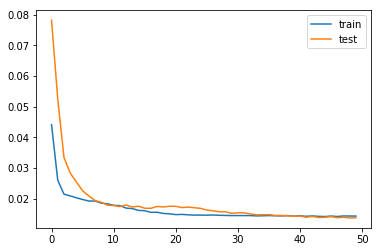

In [10]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [12]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.352


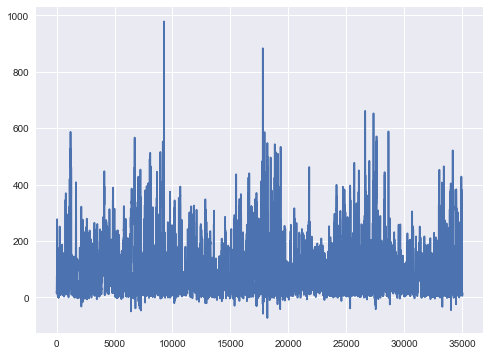

In [16]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8,6 # Big graphs unless specified
sns.set(color_codes=True) # Set style and color of graphs
plt.plot(inv_yhat)
plt.show()

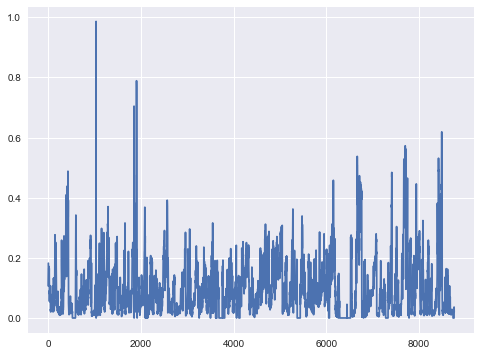

In [17]:
plt.plot(train_y)
plt.show()